# Using CLMM on Real Datasets

_the LSST-DESC CLMM team_

This notebook can be run on NERSC.

Here we demonstrate how to run CLMM on real observational datasets. As an example, we use the data from the Dark Energy Survey (DES) public releases. The catalogs can be accessed from the NOIRLab Astro Data Lab.

The steps in this notebook includes:
- [Setting things up](#Setup)
- [Selecting a cluster](#Selecting_a_cluster)
- [Downloading the published catalog at the cluster field](#Downloading_the_catalog)
- [Loading the catalog into CLMM](#Loading_the_catalog)
- [Running CLMM on the dataset](#Running_CLMM)

Acknowledgement

DES data: https://des.ncsa.illinois.edu/thanks

Astro Data Lab: https://datalab.noirlab.edu/acknowledgements.php


<a id="Setup"></a>
## 1. Setup
    
We import packages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
import pickle as pkl
from pathlib import Path

<a id="Selecting_a_cluster"></a>
## 2. Selecting a cluster

We use the DES Y1 redMaPPer Catalogs (https://des.ncsa.illinois.edu/releases/y1a1/key-catalogs/key-redmapper) to select a list of high-richness (LAMBDA) galaxy clusters, which likely have high masses.

Name | RA (deg) | DEC (deg) | Z_LAMBDA | LAMBDA | Note
- | - | - | - | - | -
RMJ025415.5-585710.7 | 43.564574 | -58.95297 | 0.429804 | 234.50368 | --
RMJ051637.4-543001.6 | 79.155704 | -54.500456 | 0.30416065 | 195.06956 | ACO S520
RMJ224851.8-443106.3 | 342.215897 | -44.518403 | 0.3514858 | 178.83827 | --
...





<a id="Downloading_the_catalog"></a>
## 3. Downloading the catalog at the cluster field

We consider RMJ051637.4-543001.6 (ACO S520) as an example.
We can access the DES catalog from NOIRLab Data Lab (https://datalab.noirlab.edu/query.php?name=des_dr1.shape_metacal_riz_unblind). No registration is required.
We make the query and download the catalogs in "Query Interface". 
We use `coadd_objects_id` to cross match the shape catalog and photo-z catalog (https://datalab.noirlab.edu/query.php?name=des_dr1.photo_z). 
Since the cluster is at redshift about 0.3, a radius of 0.3 deg would be about a radial distance of 5 Mpc. 
The final catalog includes shape info and photo-z. 
Here is an example of the query SQL command. 
The query could take a few minutes and the size of the catalog is about 1.4 MB (.csv). 

```
SELECT P.mean_z, 
C.ra, C.dec, C.e1, C.e2, C.r11, C.r12, C.r21, C.r22 
FROM des_dr1.photo_z as P
INNER JOIN des_dr1.shape_metacal_riz_unblind as C
ON P.coadd_objects_id=C.coadd_objects_id
WHERE 't' = Q3C_RADIAL_QUERY(C.ra, C.dec,79.155704, -54.500456, 0.3) 
AND P.minchi2<1
AND P.z_sigma<0.1
AND C.flags_select=0

```


<a id="Loading_the_catalog"></a>
## 4. Loading the catalog into CLMM

Once we have the catalog, we read in the catalog, make cuts on the catalog, and adjust column names to prepare for the analysis in CLMM.




In [2]:
%%time
# Assume the downloaded catalog is at this path:
filename = "../../../../ACOS520_DES.csv"
catalog = filename.replace('.csv', '.pkl')
if not Path(catalog).is_file():
    data_0 = Table.read(filename, format="ascii.csv")
    pkl.dump(data_0, open(catalog,"wb"))
else:
    data_0 = pkl.load(open(catalog,"rb"))

CPU times: user 3.56 ms, sys: 679 µs, total: 4.24 ms
Wall time: 3.28 ms


In [3]:
print(data_0.colnames)

['mean_z', 'ra', 'dec', 'e1', 'e2', 'r11', 'r12', 'r21', 'r22']


### Shear response
Shears in the DES data have been measured using the `metacal` method and the catalog provides the shear response terms ($r11,r22, r12, r21$) required to calibrate the shear values. 

In [4]:
print(np.mean(data_0['r11']), np.mean(data_0['r22']))
print(np.mean(data_0['r12']), np.mean(data_0['r21']))
r_diag = np.mean([np.mean(data_0['r11']), np.mean(data_0['r22'])])
r_off_diag = np.mean([np.mean(data_0['r12']), np.mean(data_0['r21'])])
print(r_diag, r_off_diag, r_off_diag/r_diag)

0.7105854684953065 0.7070498820143472
-0.017056656529555743 0.008455599747631375
0.7088176752548268 -0.004300528390962184 -0.006067185598068083


The diagonal terms are close to each other. The off-diagonal terms are much smaller (<1%).
We use the mean of the diagonal terms to reduce noise.
We also skip the selection bias since it is typically at percent level.

In [5]:
# Adjust column names.
def adjust_column_names(catalog_in):
    # We consider a map between new and old column names.
    # Note we have considered shear calibration here.
    column_name_map = {
        "ra": "ra",
        "dec": "dec",
        'z': "mean_z", 
        "e1": "e1",
        "e2": "e2",
    }
    
    catalog_out = Table()
    for i in column_name_map:
        catalog_out[i] = catalog_in[column_name_map[i]]
    
    catalog_out["e1"] /= r_diag
    catalog_out["e2"] /= r_diag
    
    return catalog_out

obs_galaxies = adjust_column_names(data_0)

select = (obs_galaxies["e1"]**2 + obs_galaxies["e2"]**2 <=1.)
print(np.sum(~select) )
obs_galaxies = obs_galaxies[select]

0


### Basic visualization

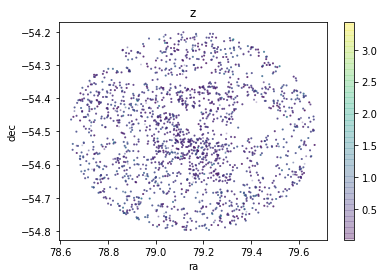

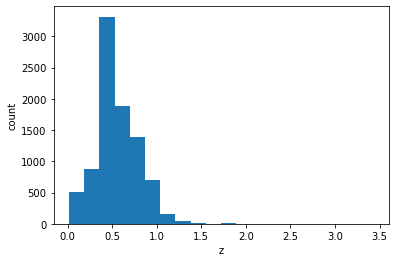

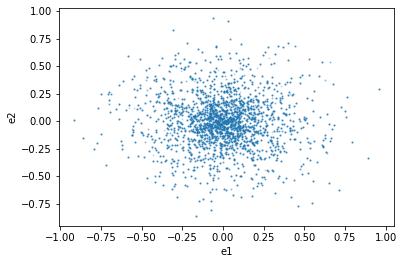

In [6]:
def make_plots(catalog_in):
    # Scatter plot
    plt.figure()
    plt.scatter(catalog_in["ra"], catalog_in["dec"], c=catalog_in['z'], s=1., alpha=0.2)
    plt.colorbar()
    plt.xlabel("ra")
    plt.ylabel("dec")
    plt.title("z")
    
    # Histogram
    plt.figure()
    plt.hist(catalog_in['z'], bins=20)
    plt.xlabel('z')
    plt.ylabel("count")
    
    # Relation
    plt.figure()
    plt.scatter(catalog_in["e1"], catalog_in["e2"], s=1., alpha=0.2)
    plt.xlabel("e1")
    plt.ylabel("e2")

make_plots(obs_galaxies)

<a id="Running_CLMM"></a>
## 5. Running CLMM on the dataset
We use the functions similar to `examples/Paper_v1.0/gt_and_use_case.ipynb`.

### Make a galaxy cluster object

In [7]:
from clmm import Cosmology
import clmm

cosmo = Cosmology(H0=70.0, Omega_dm0=0.27-0.045, Omega_b0=0.045, Omega_k0=0.0)

# We consider RMJ051637.4-543001.6 (ACO S520)
cluster_z = 0.30416065 # Cluster redshift
cluster_ra = 79.155704 # Cluster Ra in deg
cluster_dec = -54.500456 # Cluster Dec in deg
 
# Select background galaxies    
obs_galaxies = obs_galaxies[(obs_galaxies['z']>(cluster_z+0.1))&(obs_galaxies['z']<1.5)]

obs_galaxies['id'] = np.arange(len(obs_galaxies))

# Put galaxy values on arrays
gal_ra = obs_galaxies['ra'] # Galaxies Ra in deg
gal_dec = obs_galaxies['dec'] # Galaxies Dec in deg
gal_e1 = obs_galaxies['e1'] # Galaxies elipticipy 1
gal_e2 = obs_galaxies['e2'] # Galaxies elipticipy 2
gal_z = obs_galaxies['z'] # Galaxies observed redshift
gal_id = obs_galaxies['id'] # Galaxies ID

# Create a GCData with the galaxies.
galaxies = clmm.GCData([gal_ra, gal_dec, gal_e1, gal_e2, gal_z, gal_id],
                      names=['ra', 'dec', 'e1', 'e2', 'z', 'id'])

# Create a GalaxyCluster.
cluster = clmm.GalaxyCluster("Name of cluster", cluster_ra, cluster_dec,
                                   cluster_z, galaxies)

### Measure the shear profile

In [8]:
import clmm.dataops as da

# Convert ellipticities into shears for the members.
cluster.compute_tangential_and_cross_components()
print(cluster.galcat.colnames)

# Measure profile and add profile table to the cluster. 
cluster.make_radial_profile(bins=da.make_bins(0.2, 5.0, 7, method='evenlog10width'),
                            bin_units="Mpc",
                            cosmo=cosmo,
                            include_empty_bins=False,
                            gal_ids_in_bins=True,
                           )
print(cluster.profile.colnames)

['ra', 'dec', 'e1', 'e2', 'z', 'id', 'theta', 'et', 'ex']
['radius_min', 'radius', 'radius_max', 'gt', 'gt_err', 'gx', 'gx_err', 'z', 'z_err', 'n_src', 'gal_id']


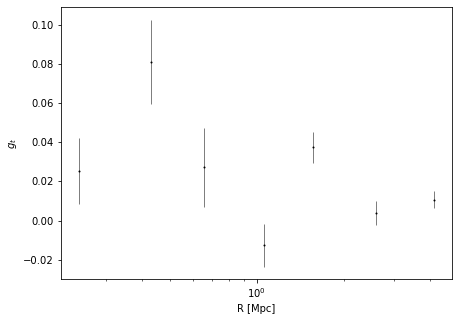

In [9]:
fig, ax = plt.subplots(figsize=(7,5), ncols=1, nrows=1)
errorbar_kwargs = dict(linestyle='', marker='o',
    markersize=1, elinewidth=.5, capthick=.5)
ax.errorbar(cluster.profile['radius'], cluster.profile['gt'],
             cluster.profile['gt_err'], c='k', **errorbar_kwargs)
ax.set_xlabel('R [Mpc]', fontsize = 10)
ax.set_ylabel(r'$g_t$', fontsize = 10)
ax.set_xscale('log')
plt.show()

### Theoretical predictions

In [10]:
from clmm.utils import convert_units

# Model relying on the overall redshift distribution of the sources (WtG III Applegate et al. 2014).
z_inf = 1000
concentration = 4.

bs_mean = np.mean(clmm.utils.compute_beta_s(cluster.galcat['z'], cluster_z, z_inf, cosmo))
bs2_mean = np.mean(clmm.utils.compute_beta_s(cluster.galcat['z'], cluster_z, z_inf, cosmo)**2)

def predict_reduced_tangential_shear_redshift_distribution(profile, logm):

    gt = clmm.compute_reduced_tangential_shear(
        r_proj=profile['radius'], # Radial component of the profile
        mdelta=10**logm, # Mass of the cluster [M_sun]
        cdelta=concentration, # Concentration of the cluster
        z_cluster=cluster_z, # Redshift of the cluster
        z_source=(bs_mean, bs2_mean), # tuple of (bs_mean, bs2_mean)
        z_src_info='beta',
        approx='order1',
        cosmo=cosmo,
        delta_mdef=200,
        massdef='critical',
        halo_profile_model='nfw')
    return gt


# Model using individual redshift and radial information, to compute the averaged shear in each radial bin, based on the galaxies actually present in that bin.
cluster.galcat['theta_mpc'] = convert_units(cluster.galcat['theta'], 'radians', 'mpc', cluster.z, cosmo)

def predict_reduced_tangential_shear_individual_redshift(profile, logm):
    return np.array([np.mean(
        clmm.compute_reduced_tangential_shear(
            # Radial component of each source galaxy inside the radial bin
            r_proj=cluster.galcat[radial_bin['gal_id']]['theta_mpc'],
            mdelta=10**logm, # Mass of the cluster [M_sun]
            cdelta=concentration, # Concentration of the cluster
            z_cluster=cluster_z, # Redshift of the cluster
            # Redshift value of each source galaxy inside the radial bin
            z_source=cluster.galcat[radial_bin['gal_id']]['z'],
            cosmo=cosmo,
            delta_mdef=200,
            massdef='critical',
            halo_profile_model='nfw'
        )) for radial_bin in profile])


### Mass fitting

In [11]:
mask_for_fit = cluster.profile['n_src'] > 2
data_for_fit = cluster.profile[mask_for_fit]

from clmm.support.sampler import fitters
def fit_mass(predict_function):
    popt, pcov = fitters['curve_fit'](predict_function,
        data_for_fit, 
        data_for_fit['gt'], 
        data_for_fit['gt_err'], bounds=[10.,17.])
    logm, logm_err = popt[0], np.sqrt(pcov[0][0])
    return {'logm':logm, 'logm_err':logm_err,
            'm': 10**logm, 'm_err': (10**logm)*logm_err*np.log(10)}

In [12]:
%%time
fit_redshift_distribution = fit_mass(predict_reduced_tangential_shear_redshift_distribution)
fit_individual_redshift = fit_mass(predict_reduced_tangential_shear_individual_redshift)

CPU times: user 582 ms, sys: 4.13 ms, total: 586 ms
Wall time: 583 ms


In [13]:
print(f'Best fit mass for N(z) model                     = {fit_redshift_distribution["m"]:.3e} +/- {fit_redshift_distribution["m_err"]:.3e} Msun')
print(f'Best fit mass for individual redshift and radius = {fit_individual_redshift["m"]:.3e} +/- {fit_individual_redshift["m_err"]:.3e} Msun')

Best fit mass for N(z) model                     = 3.210e+14 +/- 1.129e+14 Msun
Best fit mass for individual redshift and radius = 5.172e+14 +/- 1.716e+14 Msun


### Visualization of the results

In [14]:
def get_predicted_shear(predict_function, fit_values):
    gt_est = predict_function(data_for_fit, fit_values['logm'])
    gt_est_err = [predict_function(data_for_fit, fit_values['logm']+i*fit_values['logm_err'])
                          for i in (-3, 3)]
    return gt_est, gt_est_err

gt_redshift_distribution, gt_err_redshift_distribution =  get_predicted_shear(predict_reduced_tangential_shear_redshift_distribution, fit_redshift_distribution)
gt_individual_redshift, gt_err_individual_redshift =  get_predicted_shear(predict_reduced_tangential_shear_individual_redshift, fit_individual_redshift)

In [15]:
chi2_redshift_distribution_dof = np.sum((gt_redshift_distribution-data_for_fit['gt'])**2/(data_for_fit['gt_err'])**2)/(len(data_for_fit)-1)
chi2_individual_redshift_dof = np.sum((gt_individual_redshift-data_for_fit['gt'])**2/(data_for_fit['gt_err'])**2)/(len(data_for_fit)-1)

print(f'Reduced chi2 (N(z) model) = {chi2_redshift_distribution_dof}')
print(f'Reduced chi2 (individual (R,z) model) = {chi2_individual_redshift_dof}')

Reduced chi2 (N(z) model) = 4.78016508936381
Reduced chi2 (individual (R,z) model) = 4.411023500984622


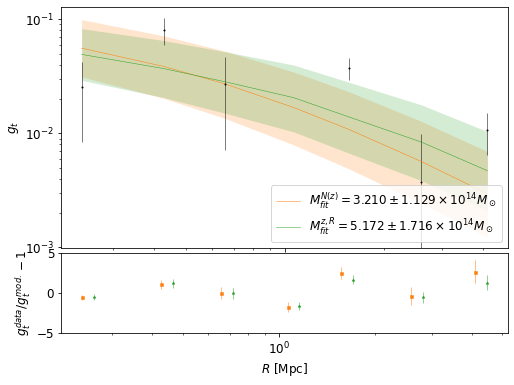

In [16]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(8,6),
                       gridspec_kw={'height_ratios': [3, 1],'wspace': 0.4,'hspace': 0.03});

ax[0].errorbar(data_for_fit['radius'],data_for_fit['gt'], data_for_fit['gt_err'],
             c='k',
            **errorbar_kwargs)

# Points in grey have not been used for the fit.
ax[0].errorbar(cluster.profile['radius'][~mask_for_fit], cluster.profile['gt'][~mask_for_fit],
               cluster.profile['gt_err'][~mask_for_fit], 
               c='grey',**errorbar_kwargs)

pow10 = 14
mlabel = lambda name, fits: fr'$M_{{fit}}^{{{name}}} = {fits["m"]/10**pow10:.3f}\pm{fits["m_err"]/10**pow10:.3f}\times 10^{{{pow10}}} M_\odot$'

# The model for the 1st method.
ax[0].loglog(data_for_fit['radius'], gt_redshift_distribution,'-C1', 
           label=mlabel('N(z)', fit_redshift_distribution),
             lw=.5)
ax[0].fill_between(data_for_fit['radius'], *gt_err_redshift_distribution, lw=0, color='C1', alpha=.2)

# The model for the 2nd method.
ax[0].loglog(data_for_fit['radius'], gt_individual_redshift,'-C2', 
           label=mlabel('z,R', fit_individual_redshift),
             lw=.5)
ax[0].fill_between(data_for_fit['radius'], *gt_err_individual_redshift, lw=0, color='C2', alpha=.2)


ax[0].set_ylabel(r'$g_t$', fontsize = 12)
ax[0].legend(fontsize=12, loc=4)
ax[0].set_xticklabels([])
ax[0].tick_params('x', labelsize=12)
ax[0].tick_params('y', labelsize=12)
ax[1].set_ylim(1.e-3,0.5)


errorbar_kwargs2 = {k:v for k, v in errorbar_kwargs.items() if 'marker' not in k}
errorbar_kwargs2['markersize'] = 3
errorbar_kwargs2['markeredgewidth'] = .5

delta = (cluster.profile['radius'][1]/cluster.profile['radius'][0])**.15


ax[1].errorbar(data_for_fit['radius'], data_for_fit['gt']/gt_redshift_distribution-1,
                yerr=data_for_fit['gt_err']/gt_redshift_distribution, marker='s', c='C1', **errorbar_kwargs2)
errorbar_kwargs2['markersize'] = 3
errorbar_kwargs2['markeredgewidth'] = .5

ax[1].errorbar(data_for_fit['radius']*delta, data_for_fit['gt']/gt_individual_redshift-1,
                yerr=data_for_fit['gt_err']/gt_individual_redshift, marker='*', c='C2', **errorbar_kwargs2)
ax[1].set_xlabel(r'$R$ [Mpc]', fontsize = 12)

ax[1].set_ylabel(r'$g_t^{data}/g_t^{mod.}-1$', fontsize = 12)
ax[1].set_xscale('log')

ax[1].set_ylim(-5,5)

ax[1].tick_params('x', labelsize=12)
ax[1].tick_params('y', labelsize=12)
plt.show()

# Note since we made cuts on the catalog, the redshift distribution of the remaining sources might not be representative.

## References

Zuntz J., Sheldon E., Samuroff S., Troxel M. A., Jarvis M., MacCrann N., Gruen D., et al., 2018, MNRAS, 481, 1149. [doi:10.1093/mnras/sty2219](
http://adsabs.harvard.edu/cgi-bin/bib_query?arXiv:1708.01533)

Hoyle B., Gruen D., Bernstein G. M., Rau M. M., De Vicente J., Hartley W. G., Gaztanaga E., et al., 2018, MNRAS, 478, 592. [doi:10.1093/mnras/sty957](http://adsabs.harvard.edu/abs/2018MNRAS.478..592H)

McClintock T., Varga T. N., Gruen D., Rozo E., Rykoff E. S., Shin T., Melchior P., et al., 2019, MNRAS, 482, 1352. [doi:10.1093/mnras/sty2711](https://ui.adsabs.harvard.edu/abs/2019MNRAS.482.1352M/abstract)
